In [1]:
import os 
import time
import xarray as xr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cf

import imageio
from IPython.display import Image

import torch

#### Load input data

In [3]:
epoch = 181
mode = 'val'  # 'train', 'val', 'test'
model = 'Full_Images_200_epochs_Charbonier'

path_dir_input = os.path.join(os.getcwd(), '..', 'data', 'ERA5', 'preprocessed_separate', mode)
path_dir_target = os.path.join(os.getcwd(), '..', 'data', 'CERRA', 'preprocessed_separate', mode)

path_dir_output = os.path.join(os.getcwd(), '..', 'AirPollution_Run', model, 'output', 'data', 'valid')


print('Loading input data')
ds_input = xr.open_dataset(os.path.join(path_dir_input, f'{mode}_input_data_cams_global_daily_avg.nc'))
ds_target = xr.open_dataset(os.path.join(path_dir_target, f'{mode}_target_data_cams_europe_regional_daily_avg.nc'))
ds_output = xr.open_dataset(os.path.join(path_dir_output, f'reconstructed_y_hat_s_{epoch:04d}.nc'))

Loading input data


In [4]:
ds_input

<xarray.Dataset>
Dimensions:    (time: 130, latitude: 106, longitude: 176)
Coordinates:
  * time       (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * latitude   (latitude) float64 72.0 71.6 71.2 70.8 ... 31.2 30.8 30.4 30.0
  * longitude  (longitude) float64 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-17T05:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
ds_target

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
    level       float32 ...
  * time        (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...
Attributes:
    title:        PM25 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240101-20241231+[0H_21H]
    summary:      ENSEMBLE model hourly FORECAST of PM25 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [6]:
ds_output

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
    level       float32 ...
  * time        (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...

#### Load DataArrays

In [7]:
in_input = ds_input["pm2p5"]
in_target = ds_target["pm2p5_conc"]
in_output = ds_output["pm2p5_conc"]

In [8]:
def GIF_OneFrame(data, n, gif_name):
    # Empty list for temporal images
    image_paths = []

    plt.style.use('default')
        
    #cmap = 'jet'
    cmap = 'viridis'

    #central_lon, central_lat = 11, 48
    #extent = [-10.3, 5, 31, 46.4]
    extent = [data.longitude.min(), data.longitude.max(), data.latitude.min(), data.latitude.max()]

    #fig, ax = plt.subplots(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # plot and save images
    for i in range(10):
        ax.clear()  # Limpiar el eje para el nuevo gráfico

        timestamp = pd.Timestamp(data.coords["time"][(n) + i].values)
        formatted_time = timestamp.strftime('%Y-%m-%dT%H:%M')

        ax.set_extent(extent)
        gls = ax.gridlines(alpha=0.5, draw_labels=True, dms=True)
        gls.right_labels = False
        gls.top_labels = False
        ax.coastlines(resolution='10m')

        vmin, vmax = 0, data.isel(time=(n) + i).max()
        im0 = ax.pcolormesh(data.longitude, data.latitude, data.isel(time=(n) + i).values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

        # Add a colorbar
        cbar = fig.colorbar(im0, ax=ax, orientation='vertical', pad=0.05, aspect=30, fraction=0.03)
        cbar.set_label('PM 2.5 [µg/m³]')

        # Add a general title to the figure
        fig.suptitle('PM 2.5 [µg/m³] (time: {})'.format(formatted_time), fontsize=16, y=0.92)

        image_path = f'pixel_{i}.png'
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.03)
        image_paths.append(image_path)

        cbar.remove()

    # Create a GIF of the saved images
    with imageio.get_writer(f'{gif_name}.gif', mode='I', duration=500.0) as writer: #2000.0
        for image_path in image_paths:
            image = imageio.imread(image_path)
            writer.append_data(image)

    # Remove temporal images
    for image_path in image_paths:
        os.remove(image_path)
    
    plt.close(fig)

In [9]:
n = np.random.randint(1, int(in_target.shape[0]))
print(n)
GIF_OneFrame(in_target, n, 'PM2.5_downscaling_target')

34


/tmp/ipykernel_157044/1108567795.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


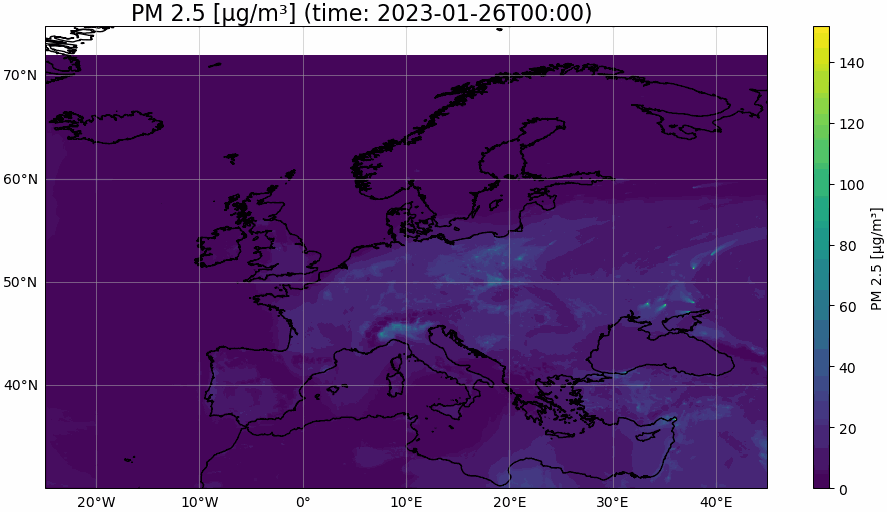

In [10]:
Image(filename='PM2.5_downscaling_target.gif')

In [11]:
n = np.random.randint(1, int(in_target.shape[0]))
print(n)
GIF_OneFrame(in_target, n, 'PM2.5_downscaling_output')

64


/tmp/ipykernel_157044/1108567795.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


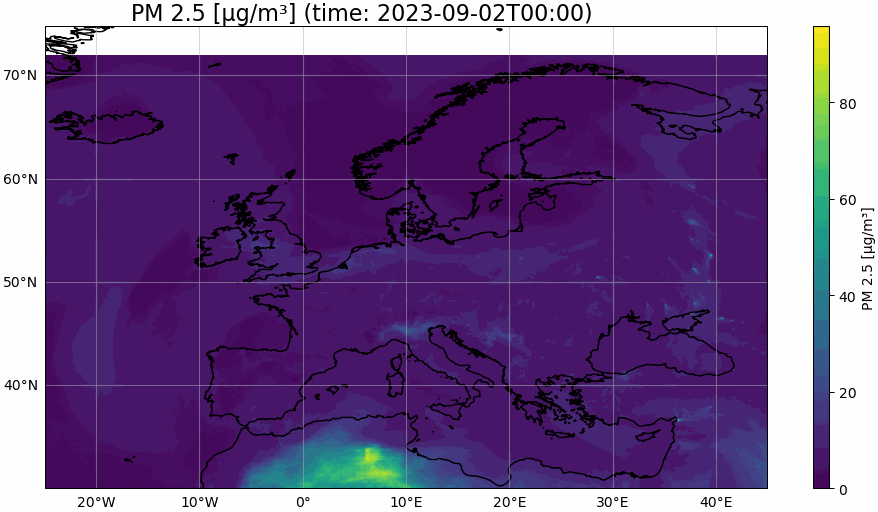

In [12]:
Image(filename='PM2.5_downscaling_output.gif')

In [13]:
def GIF_TwoFrame(data1, data2, n, gif_name):
    # Empty list for temporal images
    image_paths = []

    plt.style.use('default')
        
    #cmap = 'jet'
    cmap = 'viridis'

    #central_lon, central_lat = 11, 48
    #extent = [-10.3, 5, 31, 46.4]
    extent = [data1.longitude.min(), data1.longitude.max(), data1.latitude.min(), data1.latitude.max()]

    data = [data1, data2]

    fig, ax = plt.subplots(nrows=1,ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 6))

    # plot and save images
    for i in range(10):

        timestamp = pd.Timestamp(data1.coords["time"][(n) + i].values)
        formatted_time = timestamp.strftime('%Y-%m-%dT%H:%M')

        for j in range(2):

            ax[j].clear() 

            ax[j].set_extent(extent)
            gls = ax[j].gridlines(alpha=0.5, draw_labels=True, dms=True)
            gls.right_labels = False
            gls.top_labels = False
            ax[j].coastlines(resolution='10m')

            vmin, vmax = 0, data[j].isel(time=(n) + i).max()
            im0 = ax[j].pcolormesh(data[j].longitude, data[j].latitude, data[j].isel(time=(n) + i).values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
            if j==0:
                ax[j].set_title('Target')
            else:
                ax[j].set_title('Output')

            # Add a colorbar
            if  j==1:
                cbar = fig.colorbar(im0, ax=ax[j], orientation='vertical', pad=0.05, aspect=30, fraction=0.03)
                cbar.set_label('PM 2.5 [µg/m³]')

            # Add a general title to the figure
            fig.suptitle('Comparison of PM 2.5 [µg/m³] (time: {})'.format(formatted_time), fontsize=16, y=0.9)

        image_path = f'pixel_{i}.png'
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.05)

        cbar.remove()

        image_paths.append(image_path)

    # Create a GIF of the saved images
    with imageio.get_writer(f'{gif_name}.gif', mode='I', duration=500.0) as writer: # 2000.0
        for image_path in image_paths:
            image = imageio.imread(image_path)
            writer.append_data(image)

    # Remove temporal images
    for image_path in image_paths:
        print(image_path)
        os.remove(image_path)
    
    plt.close(fig)

In [14]:
n = np.random.randint(1, int(in_target.shape[0]))
print(n)
GIF_TwoFrame(in_target, in_output, n, 'pm2.5_downscaling_2')

114


/tmp/ipykernel_157044/38401224.py:59: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


pixel_0.png
pixel_1.png
pixel_2.png
pixel_3.png
pixel_4.png
pixel_5.png
pixel_6.png
pixel_7.png
pixel_8.png
pixel_9.png


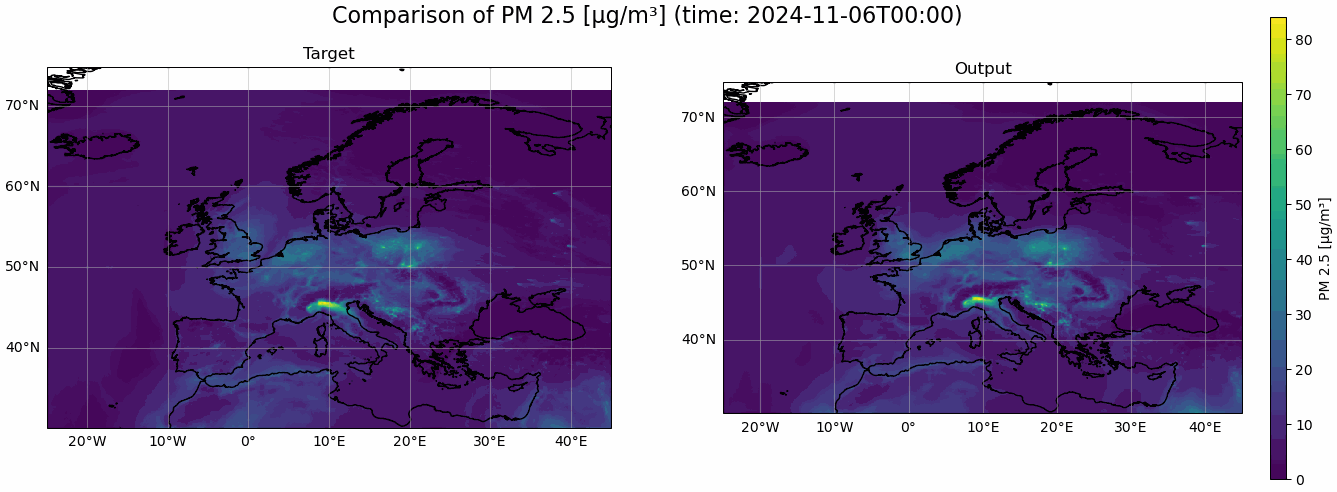

In [15]:
Image(filename='pm2.5_downscaling_2.gif')